**Данные были предоставлены мне в рамках прохождения курса по продуктовой аналитике в Яндекс Практикуме - датасеты являются собственностью Яндекса, поэтому я не могу их выложить. Весь код написан мной.**

*По условиям проект анализ данных производится в рамках работы в интернет магазине. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.*

У нас есть три датафрейма. В файле hypothesis 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

В датафреймах orders и visitors результаты А/Б тестов, которые нам надо проанализировать.

In [1]:
from collections import Counter 
import datetime as dt

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats
#import pandas_profiling as pd_p

plt.style.use('dark_background')
from IPython.core.display import display, HTML
display(HTML('<style>.container{width:80% !important;}</style>'))
from IPython.display import display, Markdown
pd.set_option('display.float.format', lambda x: '%.3f' %x)
pd.set_option('display.max_colwidth', None)

1. [Часть 1. Приоритизация гипотез](#step1)  
2. [Часть 2. Анализ А/Б теста](#step2)

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')
# ('/datasets/hypothesis.csv')

# приведем название колонок к нижнему регистру
hypothesis.columns = map(str.lower, hypothesis.columns)

# напишем функцию, чтобы посмотреть на общую информацию о датафрейме
#pd_p.ProfileReport(hypothesis)
def print_columns_info_missing_values_and_duplicates(df):
    print('В датафрейме присутствуют', df.loc[0 , :].count(), 'колонок.',
         'Их названия: ', df.columns.to_list())
    print(' ')
    print('----------------------------------\
-----------------------------------------')
    print(' ')
    print(df.info())
    print(' ')
    print('----------------------------------\
-----------------------------------------')
    print(' ')
    for column in df.columns:
        print('Пропусков в:', column, ':', 
             df[column].isna().sum())
    print(' ')
    print('----------------------------------\
-----------------------------------------')
    print(' ')
    print('Дубликатов в датафрейме:', df.duplicated().sum())
    
print_columns_info_missing_values_and_duplicates(hypothesis)

В датафрейме присутствуют 5 колонок. Их названия:  ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']
 
---------------------------------------------------------------------------
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
 
---------------------------------------------------------------------------
 
Пропусков в: hypothesis : 0
Пропусков в: reach : 0
Пропусков в: impact : 0
Пропусков в: confidence : 0
Пропусков в: efforts : 0
 
---------------------------------------------------------------------------
 
Дубликатов в датафрейме: 0


## Часть 1. Приоритизация гипотез <a id="step1"></a>   

У нас есть 9 гипотез по увеличению выручки интернет-магазина. Применим фреймворки ICE и RICE для того, чтобы выбрать какую гипотезу надо тестировать в первую очередь. 

###                  **Напомним, что фреймворки ICE и RICE считаются так:**


<br>

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Reach * Impact * Confidence}{Efforts}$$
</div>

In [3]:
print('Гипотезы из которых будем выбирать')
display(hypothesis['hypothesis'])

Гипотезы из которых будем выбирать


0              Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
1                                       Запустить собственную службу доставки, что сократит срок доставки заказов
2    Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3             Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар
4                                Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей
5                        Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов
6            Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
7                Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
8                                                         Запустить акцию, дающую скидку

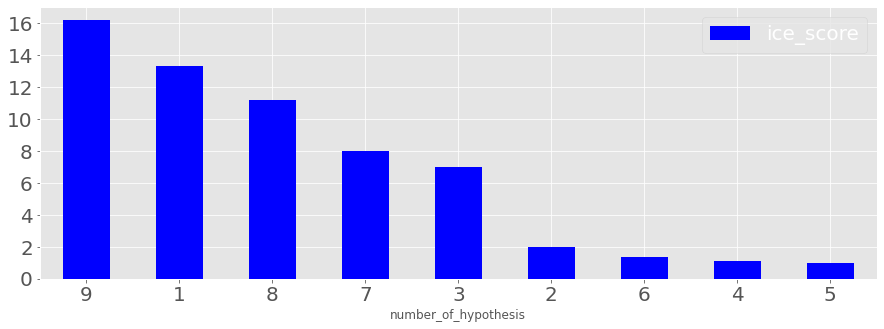

In [4]:
plt.style.use('ggplot')
# применим фреймворк ICE 
hypothesis['ice_score'] = (hypothesis['impact'] * hypothesis['confidence'] 
                           / hypothesis['efforts'])
# выведем индексы в отдельную колонку
hypothesis['number_of_hypothesis'] = hypothesis.index

# чтобы у нас не было нулевой гипотезы, прибавим к каждому значению единицу
hypothesis['number_of_hypothesis'] = hypothesis['number_of_hypothesis'] + 1

# построим barplot
hypothesis.\
    sort_values(by='ice_score', ascending=False).\
    plot(x='number_of_hypothesis', y='ice_score', grid=True, figsize=(15,5), 
         kind='bar',color='blue', fontsize = 20)
plt.xticks(rotation=0)
plt.legend(loc=1, prop={'size':20})

### Выводы:
- наиболее обещающие гипотезы пока девятая, первая и восьмая. 
- приоритизация гипотез выполнена без учета охвата аудитории, применим фреймворк rice и посмотрим, поменяется ли ситуация

Гипотеза, которую будем проверять:
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок


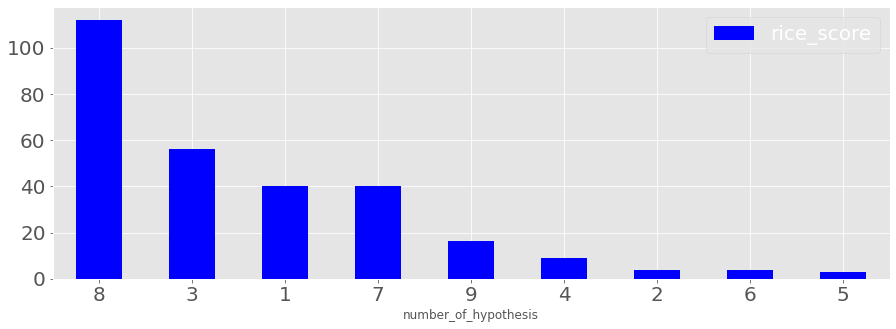

In [5]:
# посчитаем rice_score
hypothesis['rice_score'] = (hypothesis['reach'] * hypothesis['impact'] * 
                            hypothesis['confidence'] / hypothesis['efforts'])

# построим barplot
hypothesis.\
    sort_values(by='rice_score', ascending=False).\
    plot(x='number_of_hypothesis', y='rice_score', grid=True, 
         figsize=(15,5), kind='bar',color='blue', fontsize = 20)
plt.xticks(rotation=0)
plt.legend(loc=1, prop={'size':20})

# выведем гипотезу, которую будем проверять
print('Гипотеза, которую будем проверять:')
print('\033[1m' + hypothesis['hypothesis'][7] + '\033[0m')

### Выводы: 
- видимо, восьмая гипотеза имеет наибольший охват и сопоставимые с первой и девятой гипотезами параметры impact и confidence. **Тестируем восьмую гипотезу**. 

### Часть 2. Анализ результатов А/Б теста <a id="step2"></a>   

In [6]:
# загрузим данные и посмотрим на них
# ('/datasets/orders.csv')
orders = (
    pd.read_csv('orders.csv', sep = ',').
    assign(date = lambda x: pd.to_datetime(x['date'], format='%Y-%m-%d'))
)

#pd_p.ProfileReport(orders)
# выведем общую информацию о датафрейме: 
print_columns_info_missing_values_and_duplicates(orders)

В датафрейме присутствуют 5 колонок. Их названия:  ['transactionId', 'visitorId', 'date', 'revenue', 'group']
 
---------------------------------------------------------------------------
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None
 
---------------------------------------------------------------------------
 
Пропусков в: transactionId : 0
Пропусков в: visitorId : 0
Пропусков в: date : 0
Пропусков в: revenue : 0
Пропусков в: group : 0
 
--------------------------------------------------------------

In [7]:
# ('/datasets/visitors.csv')
visitors = (
    pd.read_csv('visitors.csv', sep=',').
    assign(date = lambda x: pd.to_datetime(x['date'], format='%Y-%m-%d'))
)

#pd_p.ProfileReport(visitors)
print_columns_info_missing_values_and_duplicates(visitors)

В датафрейме присутствуют 3 колонок. Их названия:  ['date', 'group', 'visitors']
 
---------------------------------------------------------------------------
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None
 
---------------------------------------------------------------------------
 
Пропусков в: date : 0
Пропусков в: group : 0
Пропусков в: visitors : 0
 
---------------------------------------------------------------------------
 
Дубликатов в датафрейме: 0


In [8]:
# создадим массив уникальных пар значений дат и групп теста
dates_groups = orders[['date', 'group']].drop_duplicates()

# получим агрегированные кумулятивные по дням данные о заказах
orders_aggregated = dates_groups.apply(lambda x: 
                        orders[np.logical_and(orders['date'] <= x['date'], 
                                              orders['group'] == x['group'])]\
                        .agg({'date':'max', 'group':'max', 
                              'transactionId': pd.Series.nunique, 
                        'visitorId':pd.Series.nunique, 'revenue':'sum'}), axis=1).\
                        sort_values(by=['date', 'group'])

# получим агрегированные кумулятивные по дням данные о посетителях 
visitors_aggregated = dates_groups.apply(lambda x: 
                                        visitors[np.logical_and(visitors['date']<= x['date'], 
                                        visitors['group'] == x['group'])]\
                                        .agg({'date':'max', 'group':'max', 
                                              'visitors':'sum'}), axis=1).\
                                        sort_values(by=['date','group'])

# сделаем общий датафрейм, где будут данные о посещениях и данные о заказах
cumulative_data = orders_aggregated.merge(visitors_aggregated, on=['date', 'group'])

# для дальнейшего удобства поменяем название колонок в общем датафрейме
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# посмотрим, все ли получилось правильно
cumulative_data.head(1)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719


### Задание 1. Построим график кумулятивной выручки по группам 

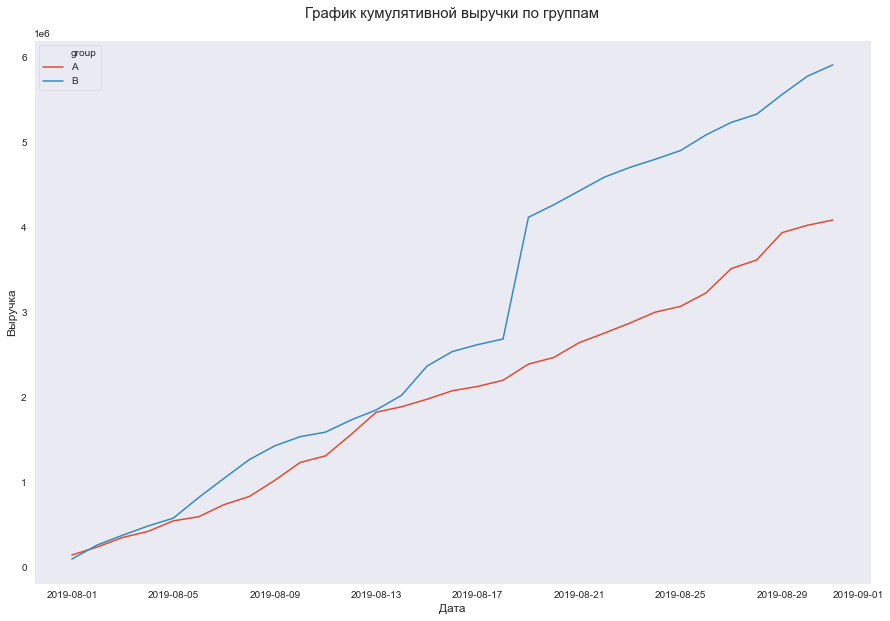

In [9]:
sns.set_style("dark")
plt.figure(figsize=(15,10))
sns.lineplot(x=cumulative_data['date'], y=cumulative_data['revenue'], 
             hue=cumulative_data['group'])
plt.title('График кумулятивной выручки по группам'+'\n', fontsize=15)
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

### Выводы:
- выручка увеличивается в обеих группах в течение всего теста
- в первые четыре дня теста выручка по группам находилась на примерно одном уровне, но после этого выручка группы B стала расти быстрее, чем для группы A
- к концу второй недели теста выручки по группам опять примерно сравнялись, но в дальнейшем у группы B был резкий рост 17 августа
- представляется, что такой резкий рост может быть связан с одним аномально большим заказом. Проверим это в нашем дальнейшем анализе

### Задание 2. Построим график кумулятивного среднего чека по группам 

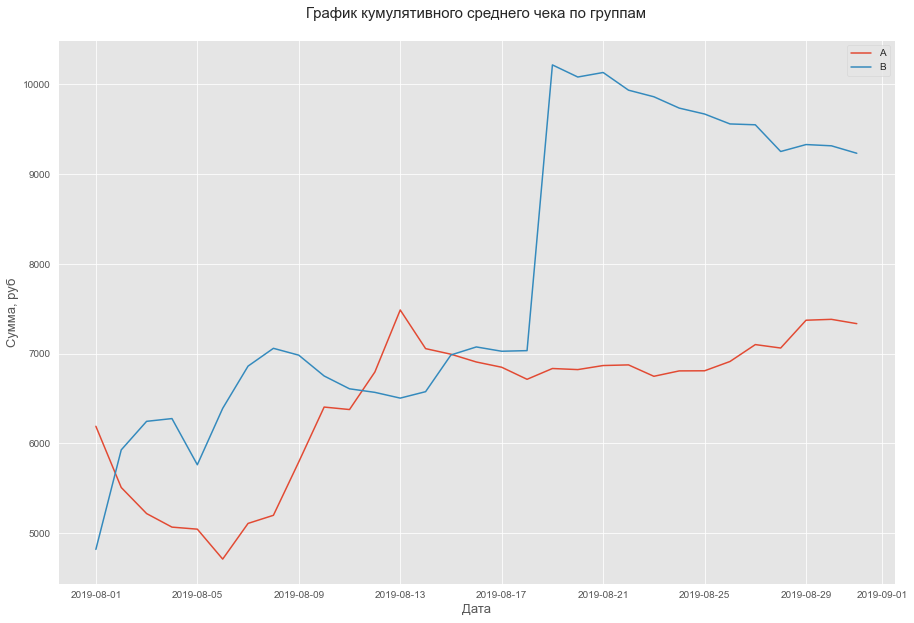

In [10]:
# для начала создадим два датафрейма с кумулятивным количеством заказов и кумулятивным количеством
# визитом для каждой из групп
cumulative_revenue_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 
                                                                         'revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 
                                                                         'revenue', 'orders']]

# построим графики изменения среднего чека
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(cumulative_revenue_a['date'], (cumulative_revenue_a['revenue'] / 
                                        cumulative_revenue_a['orders']), label='A')
plt.plot(cumulative_revenue_b['date'], (cumulative_revenue_b['revenue'] / 
                                        cumulative_revenue_b['orders']), label='B')
plt.title('График кумулятивного среднего чека по группам'+'\n', fontsize=15)
plt.xlabel('Дата', fontsize=13)
plt.ylabel('Сумма, руб', fontsize=13)
plt.legend()
plt.show()

### Выводы:
- в обеих группах размер среднего чека рос с начала эксперимента 
- до 17 августа размеры средних чеков по группам держатся примерно на одном уровне
- в группе B опять видим резкое увеличение среднего чека в промежуток с 17 по 21 августа, но после мощного выброса идет "возвращение к среднему"

### Задание 3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A 

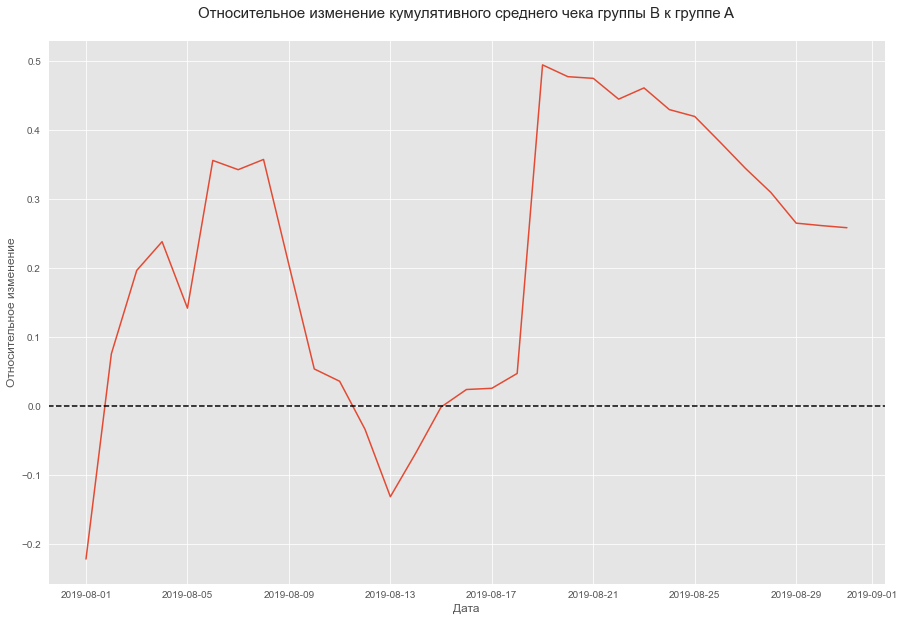

In [11]:
# соберем данные по средним чекам в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(
    cumulative_revenue_b, left_on='date', right_on='date', suffixes=['A','B']
)

# построим отношение средних чеков
merged_cumulative_revenue
plt.figure(figsize=(15,10))
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB'] / 
                                             merged_cumulative_revenue['ordersB']) / 
                                            (merged_cumulative_revenue['revenueA'] / 
                                             merged_cumulative_revenue['ordersA'])-1)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A'+'\n', 
         fontsize=15)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.show()

### Выводы:
- до 17-го числа отношение между относительными изменениями в средних чеках по группам не установилось, но **после 17-го числа в группе B произошло что-то аномальное**, что значительно повысило средний чек группы B  по отношению к среднему чеку группы A

### Задание 4. Построим график кумулятивной конверсии по группам

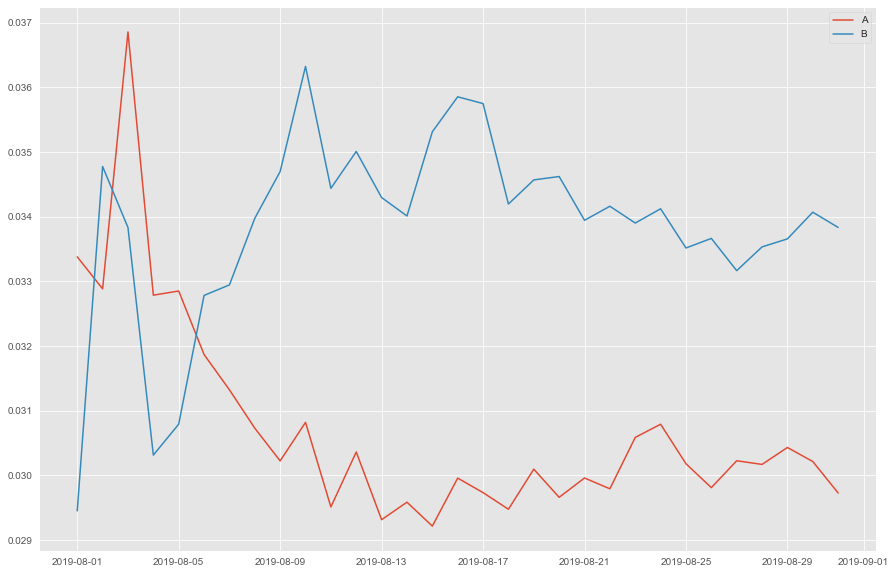

In [12]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']
plt.figure(figsize=(15,10))
plt.plot(cumulative_data_a['date'],
        cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], 
        cumulative_data_b['conversion'], label='B')
plt.legend()
plt.show()

### Выводы:
- в первые дни теста группы колебались около одного значения
- **после 5-го августа конверсия группы B стала выше и в дальнейшем это зафиксировалось**

### Задание 5. Построим график относительного изменения кумулятивной конверсии группы B к группе A

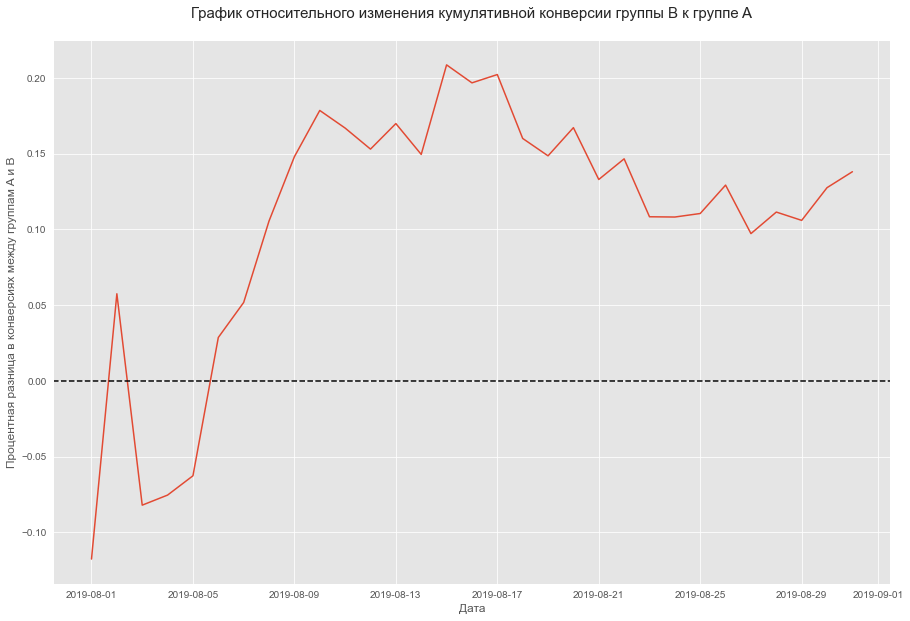

In [13]:
# сделаем датафрейм с конверсиями по обеим группам
merged_cumulative_conversions = cumulative_data_a[['date', 'conversion']].\
merge(cumulative_data_b[['date', 'conversion']], left_on='date', 
      right_on='date', how='left', suffixes=['A', 'B'])

# построим график 
plt.figure(figsize=(15,10))
plt.plot(merged_cumulative_conversions['date'],
        (merged_cumulative_conversions['conversionB']/
        merged_cumulative_conversions['conversionA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Процентная разница в конверсиях между группам A и B')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A'+'\n', 
          fontsize=15)
plt.show()

### Выводы:
- в первую неделю а/б теста конверсии колебались и из данных нельзя было сделать вывод 
- **после первой недели а/б теста конверсия группы B стала повышаться и на данный момент она выше, чем конверсия группы A, в среднем на 10-15%**
- **отношение конверсий уже остановилось**, можно сделать вывод, что конверсия в группе B выше

### Задание 6. Построим точечный график количества заказов по пользователям

Десять пользователей, которые сделали у нас больше всех заказов:
         user_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


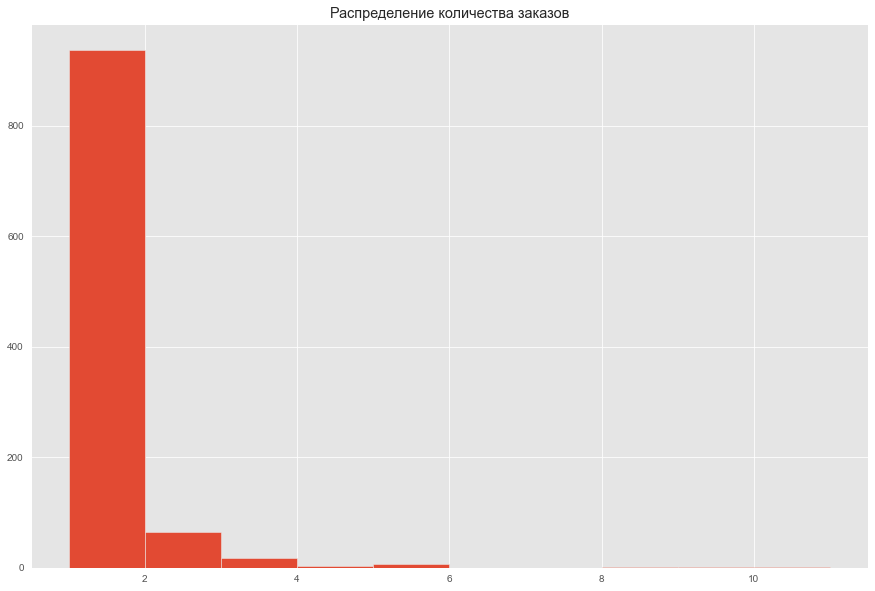

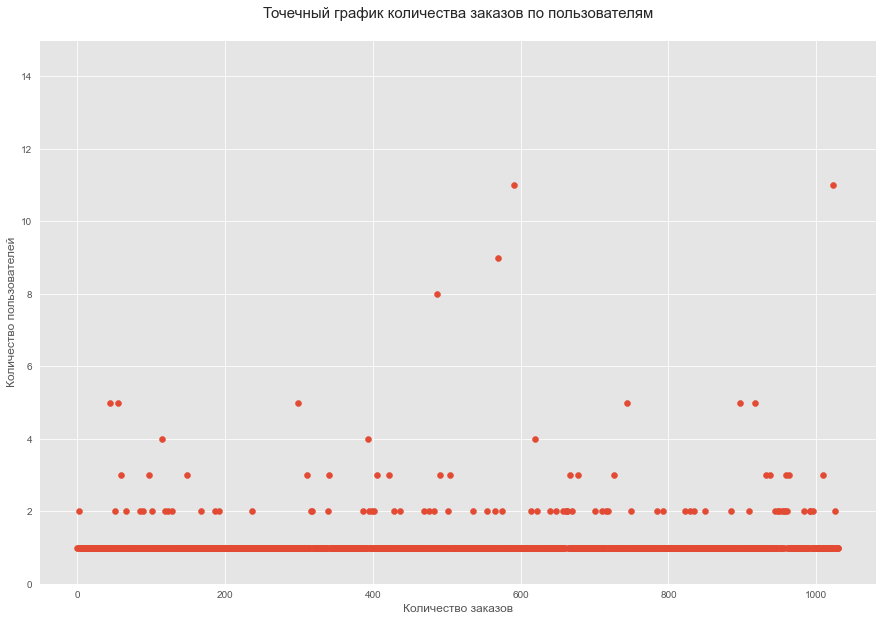

In [14]:
# посмотрим, сколько раз у нас покупают пользователи
orders_by_users = orders.drop(['group', 'revenue', 'date'], axis=1).\
groupby('visitorId', as_index=False).agg({'transactionId':pd.Series.nunique})
orders_by_users.columns = ['user_id', 'orders']

# посмотрим на таблицу
print('Десять пользователей, которые сделали у нас больше всех заказов:')
print(orders_by_users.sort_values(by='orders', ascending=False).\
      head(10))

# посмотрим на распределение
plt.figure(figsize=(15,10))
plt.title('Распределение количества заказов')
plt.hist(orders_by_users['orders'])
plt.show()

# построим скаттер плот
x_values = pd.Series(range(0,len(orders_by_users)))
plt.figure(figsize=(15,10))
plt.scatter(x_values, orders_by_users['orders'])
plt.ylim(0, 15)
plt.title('Точечный график количества заказов по пользователям'+'\n', fontsize=15)
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

### Выводы: 
- у большинства пользователей по 1 заказу 
- доля пользователей с заказами от 2 до 4 высока
- чтобы понять, считать ли пользователей, которые заказали от 2 до 4 раз аномальными, надо посчитать перцентили

### Задание 7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [15]:
print(np.percentile(orders_by_users['orders'], [95,99]))

[2. 4.]


### Выводы:
- не более 5-ти процентов пользователей совершили более 2-х заказов 
- не более 1-го процента пользователей совершают 4 и более заказа
- выберем 2 заказа за нижнюю границу

### Задание 8. Построим точечный график стоимостей заказов. 

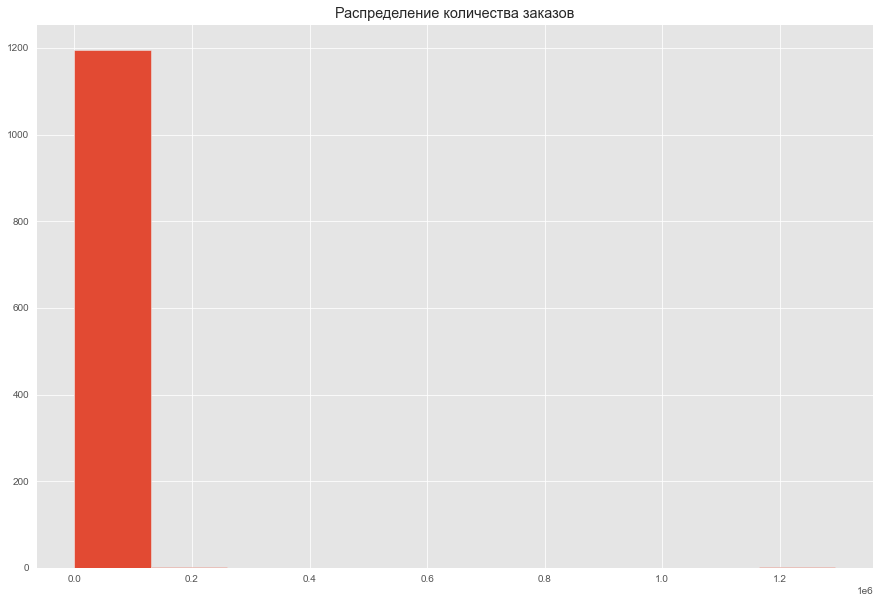

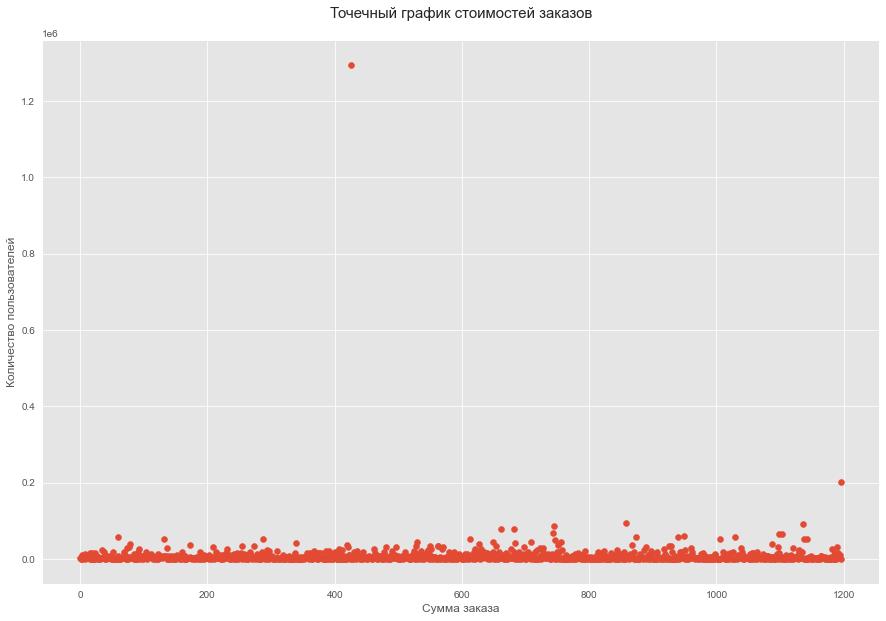

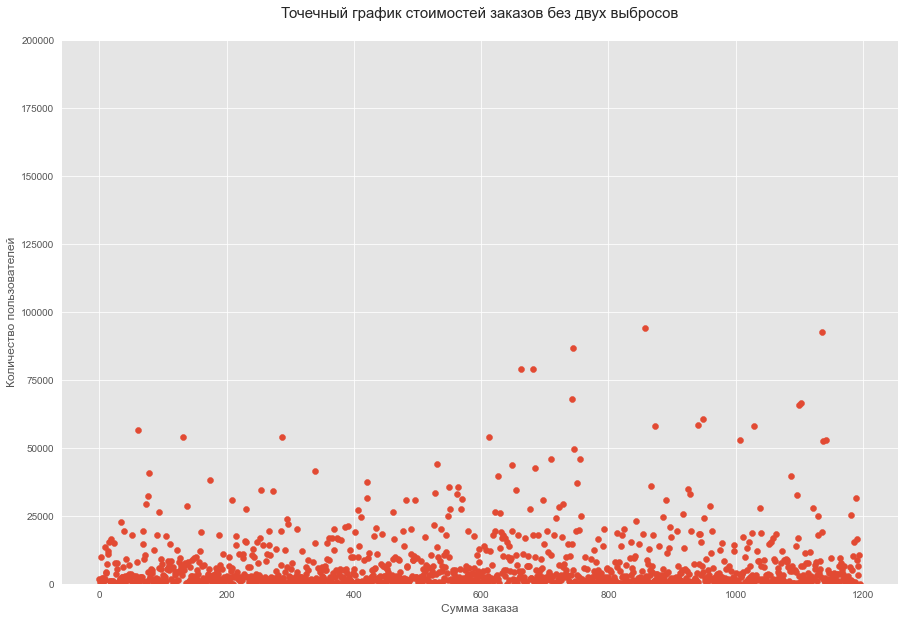

In [16]:
# для начала посмотрим на распределение данной величины
plt.figure(figsize=(15,10))
plt.title('Распределение количества заказов')
plt.hist(orders['revenue'])
plt.show()


x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15,10))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов'+'\n', 
          fontsize=15)
plt.xlabel('Сумма заказа')
plt.ylabel('Количество пользователей')
plt.show()

# у нас есть два аномальных заказа: один больше 1 млн, а другой около 200 тысяч. 
# Посмотрим на данные без них - для этого изменим параметр ylim 
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15,10))
plt.ylim(0, 200000)
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов без двух выбросов'+'\n', 
          fontsize=15)
plt.xlabel('Сумма заказа')
plt.ylabel('Количество пользователей')
plt.show()

### Выводы: 
- подавляющее большинство заказов укладываются в интервал от 0 до 50000. 
- есть два выброса
- чтобы узнать, какие заказы считать аномальными, посчитаем перцентили 

### Задание 9. Посчитаем 95-й и 99-й перцентили стоимостей заказов

In [17]:
print(np.percentile(orders['revenue'], [95,99]))

[28000.  58233.2]


### Выводы:
- не более 5% заказов принесли нам более 28 тысяч
- не более 1-го % заказов принесли нам более 58 233 рублей
- выберем 28 тысяч за нижнюю границу

### Задание 10. Посчитаем статистическую значимость различий в конверсии между группами

In [18]:
for df in [orders, visitors]:
    display(df.info(), df.columns.to_list())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

['transactionId', 'visitorId', 'date', 'revenue', 'group']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

['date', 'group', 'visitors']

**Зададим нулевую и альтернативную гипотезы:**

H0: *конверсия в группе B равна конверсии в группе A*

HA: *конверсия в группе B не равна конверсии в группе A*

In [19]:
# посчитаем количество пользователей в выбранную дату для группы A
# для проведения статистического теста нам понадобятся люди, которые купили и люди, 
# которые заходили к нам, но не купили. Возьмем эти данные
visitors_a_daily = visitors[visitors['group'] == "A"][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']
orders_by_users_a = orders[orders['group'] == 'A'].groupby('visitorId', 
                                                           as_index=False)\
.agg({'transactionId': pd.Series.nunique})

# поменяем названия колонок
orders_by_users_a.columns = ['user_id', 'orders']

# теперь склеим данные по заказам пользователям, с объектом Series, где будет 0 у всех, кто заходил к нам
# но не купил 
sample_a = pd.concat([orders_by_users_a['orders'], 
                      pd.Series(0, index=np.arange(
                          visitors_a_daily['visitors_per_date_a']\
                           .sum() - len(orders_by_users_a['orders'])),
                                name='orders')], axis=0)

# теперь сделаем то же самое для группы B
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']
orders_by_users_b = orders[orders['group'] == 'B'].groupby('visitorId', 
                                                           as_index=False)\
.agg({'transactionId':pd.Series.nunique})

# переименуем название колонок
orders_by_users_b.columns = ['user_id', 'orders']
sample_b = pd.concat([orders_by_users_b['orders'], 
                      pd.Series(0, index=np.arange(
                          visitors_b_daily['visitors_per_date_b']\
                            .sum() - len(orders_by_users_b['orders'])),
                                name='orders')], axis=0)

# применим статистический критерий Манна-Уитни
mw_conversion_test_with_outliers = stats.mannwhitneyu(sample_a, sample_b)
alpha = 0.05
print('p-значение составляет: {0:.3f}'.format(
    mw_conversion_test_with_outliers.pvalue))

# зададим условия, при которых сможем отвергнуть или не отвергать нулевую гипотезу
if mw_conversion_test_with_outliers.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не можем отвергнуть нулевую гипотезу')

# посчитаем относительную разницу в конверсиях между группами     
print('В группе A конверсия меньше на {0:.2%}'.\
      format(sample_a.mean()/sample_b.mean()-1))

p-значение составляет: 0.008
Отвергаем нулевую гипотезу
В группе A конверсия меньше на -12.13%


In [20]:
print('В группе В конверсия больше на {0:.2%}'.\
      format(abs(sample_b.mean()/sample_a.mean()-1)))

В группе В конверсия больше на 13.81%


### Выводы:
- в "грязных" данных есть статистически значимая разница среди конверсий по группам. 
- В группе A конверсия меньше на 12.13%. Это не удивительно, потому что когда мы строили графики кумулятивных конверсий, на них было видно, что конверсия в группе B в среднем на 10-15 % выше, чем в A. Вероятно, что именно это и показал нам тест.

### Задание 11. Посчитаем статистическую значимость различий в среднем чеке между группами

H0: размер среднего чека в группе B не отличается от размера среднего чека в группе A

HA: размер среднего чека в группе B отличается от размера среднего чека в группе A

Перед тем, как проводить статистический тест, посмотрим на распределения. 

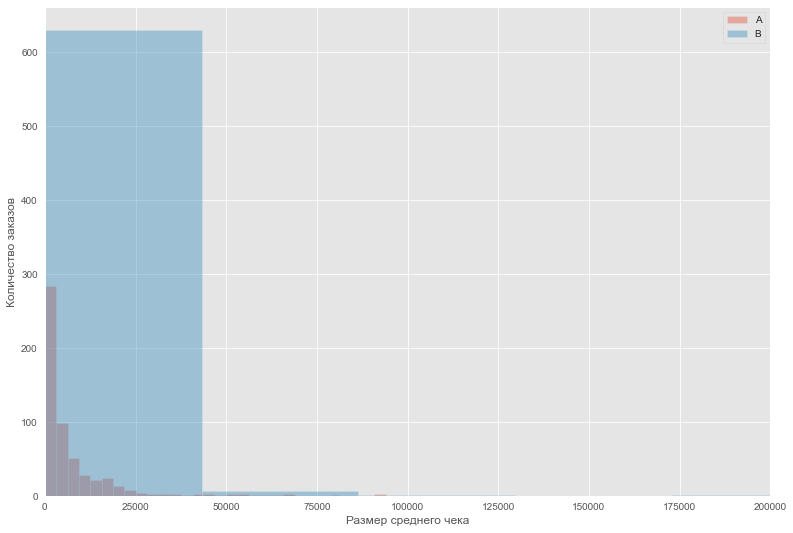

In [21]:
plt.figure(figsize=(13,9))
sns.distplot(orders[orders['group']=='A']['revenue'], 
            kde=False, bins=30, label='A')
sns.distplot(orders[orders['group']=='B']['revenue'],
            kde=False, bins=30, label='B')
plt.xlim(0, 200000)
plt.ylabel('Количество заказов')
plt.xlabel('Размер среднего чека')
plt.legend()
plt.show()

**Получили очень странный график. Возможно, что это из-за выбросов. Удалим выбросы и нарисуем его опять**

In [22]:
mw_av_receipt_test_with_outliers = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                                      orders[orders['group']=='B']['revenue'])

# выведем p-значение
print('p-значение составляет: {0:.3f}'.format(mw_av_receipt_test_with_outliers.pvalue))

# зададим условия, при которых сможем отвергнуть или не отвергать нулевую гипотезу
if mw_av_receipt_test_with_outliers.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не можем отвергнуть нулевую гипотезу')

# посчитаем относительную разницу в чеках 
diff_in_av_receipts = (orders[orders['group']=='B']
    ['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean()- 1)

print('Средний чек в группе B на {0:.2%} больше, чем в группе A'.format(diff_in_av_receipts))

p-значение составляет: 0.365
Не можем отвергнуть нулевую гипотезу
Средний чек в группе B на 25.87% больше, чем в группе A


### Выводы:
- статистической разницы в размерах средних чеков по группам нет
- несмотря на это, средний чек в группе B почти на 26% выше, чем в группе A

### Задание 12. Уберем выбросы и посчитаем статистическую значимость в конверсиях по группам. 

In [23]:
# np.percentile(orders_by_users['orders'], 95)
orders_by_users = orders.groupby('visitorId', as_index=False).\
agg({'transactionId':pd.Series.nunique})

# возьмем айди пользователей, которые заказывали больше 2-х раз
users_with_many_orders = orders_by_users[orders_by_users['transactionId'] > np.\
                                         percentile(orders_by_users['transactionId'], 
                                                    95)]['visitorId']

# теперь возьмем пользователей, которые заказывали дороже, чем на 28 тысяч 
users_with_expensive_orders = orders[orders['revenue'] > np.\
                                    percentile(orders['revenue'], 95)]['visitorId']

# сведем обе категории аномальных пользователей в один датасет 
abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders],
                           axis=0).drop_duplicates().sort_values()

# посмотрим, что по получилось
print(abnormal_users.head(3), 
      abnormal_users.shape)

# отфильтруем наши семплы
sample_a_filtered = pd.concat([orders_by_users_a[np.logical_not(
    orders_by_users_a['user_id'].isin(abnormal_users))]['orders'], 
    pd.Series(0, index=np.arange(visitors_a_daily['visitors_per_date_a']\
            .sum() - len(orders_by_users_a['orders'])),
                name='orders')], axis=0)
    
sample_b_filtered = pd.concat([orders_by_users_b[np.logical_not(
    orders_by_users_b['user_id'].isin(abnormal_users))]['orders'], 
    pd.Series(0, index=np.arange(visitors_b_daily['visitors_per_date_b']\
            .sum() - len(orders_by_users_b['orders'])),
                name='orders')], axis=0)

1099    148427295
44      199603092
928     204675465
Name: visitorId, dtype: int64 (83,)


In [24]:
mw_conversion_test_without_outliers = stats.mannwhitneyu(sample_a_filtered, 
                                                         sample_b_filtered)
alpha = 0.05
print('p-значение составляет: {0:.3f}'.format(mw_conversion_test_without_outliers.pvalue))
if mw_conversion_test_without_outliers.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не можем отвергнуть нулевую гипотезу')
print('В группе A конверсия меньше на {0:.2%}'.\
      format(abs(sample_a_filtered.mean()/sample_b_filtered.mean()-1)))

p-значение составляет: 0.006
Отвергаем нулевую гипотезу
В группе A конверсия меньше на 14.94%


### Выводы:
- без выбросов картина не изменилась, нам следует отвергнуть нулевую гипотезу, что конверсия группы A равна конверсии группы B. 
- относительная величина различия между конверсиями только увеличилась и составляет теперь около 15%
- таким образом, по итогам статистического непараметрического теста Манна-Уитни на данных с выбросами и на данных без выбросов, можно утверждать, что конверсия в группе B выше и это статистически значимое различие


### Задание 13. Посчитаем статистическую значимость в различиях между средними чеками по группам A и B по очищенным данным

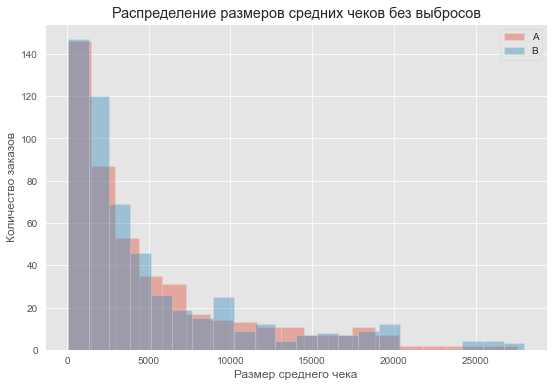

In [25]:
# посмотрим на распределение
plt.figure(figsize=(9,6))
sns.distplot(orders[np.logical_and(
        orders['group']=="A",
        np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'],
             label="A", kde=False)
sns.distplot(orders[np.logical_and(
        orders['group']=="B",
        np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'], 
             label="B", kde=False)
plt.ylabel('Количество заказов')
plt.xlabel('Размер среднего чека')
plt.title('Распределение размеров средних чеков без выбросов')
plt.legend()
plt.show()

In [26]:
# проведем тест Манна-Уитни
mw_av_receipt_test_without_outliers = stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=="A",
        np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'],
    orders[np.logical_and(
        orders['group']=="B",
        np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'])
print('p-значение составляет: {0:.3f}'.format(mw_av_receipt_test_without_outliers.pvalue))
if mw_av_receipt_test_without_outliers.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не можем отвергнуть нулевую гипотезу')


# посчитаем относительное разиличие в чеках
print('В группе A конверсия меньше на {0:.2%}'.format(
    abs(orders[np.logical_and(orders['group']=='B',
                              np.logical_not(orders['visitorId'].\
                                             isin(abnormal_users)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].\
                       isin(abnormal_users)))]['revenue'].mean() - 1)))

p-значение составляет: 0.376
Не можем отвергнуть нулевую гипотезу
В группе A конверсия меньше на 2.21%


### Выводы:
- не смогли отвергнуть нулевую гипотезу, поэтому мы не можем утверждать, что в средних чеках по двум группам есть какие-либо статистически значимые различия
- несмотря на то, что результат не изменился, мы смогли понять природу полученного результата, когда делали тест для статистических различий между средними чеками по данным с выбросами. Тогда мы не смогли отвергнуть нулевую гипотезу, хотя относительное различие между размерами средних чеков по группам было около 25%. Убрав выбросы, мы поняли, что такое различие существовало из-за выбросов (например, можно вспомнить что в одной из групп был аномальный заказ на 1 млн 200 тысяч). Когда мы убрали выбросы, то увидели, что различие относительных величин стало лишь 2%. 
- итоговый вывод: статистически значимой разницы в размерах средних чеков по группам нет

## Подведем итоги: 

В результате анализа результов а/б теста мы выяснили, что:
- выручка увеличивается в обеих группах в течение всего теста
- к концу второй недели теста выручки по группам опять примерно сравнялись, но в дальнейшем у группы B был резкий рост 17 августа, которой был вызван аномально большим заказом (более чем на 1 млн 200 тысяч). **Статистически значимой разницы в размерах средних чеков по группам нет**
- после 5-го августа конверсия группы B стала выше и в дальнейшем это зафиксировалось. **Мы получили статистически значимую разницу в конверсиях по двум группам**
- **Можно заканчивать а/б тест и признать его успешным. Различий в средних чеках по группам нет, но в группе B выше конверсия** 